This Python notebook contains the code to reproduce the experiments in:
> C. W. Combettes and S. Pokutta. Blended Matching Pursuit. In *Advances in Neural Information Processing Systems*, 2019.

Apart from the BMP vs. accMP experiment (Figure 2 in the paper), each experiment takes an average total ~15 min to run. The time limit can be reduced by setting the variable `time_tol` (in seconds) to a lower value;  `time_tol` is set at the beginning of each experiment. Otherwise just running every cell without configuring anything works.

# Preliminaries

In [0]:
import numpy as np
from scipy.linalg import lu
from itertools import compress

### Algebra

The functions `proj_simplex` and `proj_l1ball` are implemented from: 
> L. Condat. Fast projection onto the simplex and the $\ell$1 ball. *Mathematical Programming*, 158(1):575$-$585, 2016.

In [0]:
def indep_columns(S):
    
    '''
    Returns a submatrix of np.array(S) which columns are a basis for the linear span of the columns of S
    If the elements of S are your vectors, use np.transpose(indep_columns(np.transpose(S)))
    S: list of arrays of size n
    '''
    
    S = np.array(S)
    m, n = S.shape
    basis = []
    
    if m >= n:
        # use QR decomposition
        R = np.linalg.qr(S, 'r')
        for i in range(n):
            if abs(R[i][i]) > 1e-10:
                basis.append(i)
        return np.transpose(np.transpose(S)[basis])
    
    else:
        # use LU decomposition
        U = lu(S)[2]
        for i in range(m):
            for j in range(i, n):
                if abs(U[i][j]) > 1e-10:
                    basis.append(j)
                    break
        return np.transpose(np.transpose(S)[basis])

def proj(c, S):
    
    '''
    Projects vector c onto the linear span of the columns of S
    c: array of size n
    S: list of arrays of size n
    '''
    
    S_basis = np.transpose(indep_columns(np.transpose(S)))
    
    # calculate the projection using least-squares
    K = np.dot(S_basis, np.transpose(S_basis))
    b = np.dot(c, np.transpose(S_basis))
    beta = np.matmul(np.linalg.inv(K), b)
    
    # return the projection, its coefficients in the basis, the basis
    return np.dot(beta, S_basis), beta, S_basis

def proj_simplex(y, a):
    
    '''
    Projects y onto the simplex of radius a
    Vector y must be in the positive orthant
    y: array
    a: float
    '''
    
    if np.sum(y) <= a:
        return y
    
    else:
    
        v, vv, rho = [y[0]], [], y[0]-a
        N = len(y)

        for n in range(1, N):
            if y[n] > rho:
                rho += (y[n]-rho)/(len(v)+1)
                if rho > y[n]-a:
                    v.append(y[n])
                else:
                    vv.extend(v)
                    v = [y[n]]
                    rho = y[n]-a

        if len(vv) > 0:
            for w in vv:
                if w > rho:
                    v.append(w)
                    rho += (w-rho)/len(v)

        c, flag = len(v), 1
        while flag == 1:
            for w in v:
                if w <= rho:
                    v.remove(w)
                    rho += (rho-w)/len(v)
            if len(v) != c:
                c, flag = len(v), 1
            else:
                flag = 0

        tau, K = rho, len(v)
        
        z = np.zeros(N)
        for n in range(N):
            z[n] = max(y[n]-tau, 0)
    
        return z

def proj_l1ball(x, a):
    
    '''
    Projects x onto the l1-ball of radius a
    x: array
    a: float
    '''
    
    if np.linalg.norm(x, 1) <= a:
        return x
    
    else:
        y = np.abs(x)
        z = proj_simplex(y, a)
        return np.sign(x)*z

def find_index(a, D):
    
    '''
    Finds index of a in D
    a: array
    D: list of arrays
    '''
    
    for i in range(len(D)):
        if np.all(D[i] == a):
            return i

def correct(S, alpha):
    
    '''
    Returns a basis for lin(S) among S, and the corresponding list of coefficients
    S: list of size m of arrays of size n
    alpha: list of size m
    '''
    
    S_basis = np.transpose(indep_columns(np.transpose(S)))
    
    # compute new coefficients
    beta = np.matmul(np.linalg.pinv(np.transpose(S_basis)), np.transpose(S))
    alpha_basis = [0]*len(S_basis)
    for i in range(len(S_basis)):
        alpha_basis[i] = np.dot(alpha, beta[i])
    
    return list(S_basis), alpha_basis

### Optimization

In [0]:
def line_search(f, grad_f, x, p, tol=1e-6):
    
    '''
    Minimizes f(x+gamma*p) as a function of scalar gamma
    f, grad_f: callables
    x, p: arrays
    tol: float
    '''
    
    # obtain segment such that minimizer is in its interior
    gamma = 1
    left, right = x-gamma*p, x+gamma*p
    while np.dot(p, grad_f(left))*np.dot(p, grad_f(right)) >= 0:
        gamma *= 2
        left -= gamma*p
        right += gamma*p
        if gamma > 1e15:
            break
    
    # apply golden-section method to segment
    gold = (1+np.sqrt(5))/2
    improv = np.inf
    while improv > tol:
        old_left, old_right = left, right
        new = left+(right-left)/(1+gold)
        probe = new+(right-new)/2
        if f(probe) <= f(new):
            left, right = new, right
        else:
            left, right = left, probe
        improv = np.linalg.norm(f(right)-f(old_right))+np.linalg.norm(f(left)-f(old_left))
    x_min = (left+right)/2
    
    # compute step-size gamma
    for i in range(len(p)):
        if p[i] != 0:
            gamma = (x_min[i]-x[i])/p[i]
            break
            
    return x_min, gamma

def segment_search(f, x, y, tol=1e-6):
    
    '''
    Minimizes f over [x, y] i.e. f(x+gamma*(y-x)) as a function of scalar gamma in [0,1]
    f: callable
    x, y: arrays
    tol: float
    '''
    
    # restrict segment of search to [x, y]
    v = (y-x).copy()
    left, right = x.copy(), y.copy()
    
    # apply golden-section method to segment
    gold = (1+np.sqrt(5))/2
    improv = np.inf
    while improv > tol:
        old_left, old_right = left, right
        new = left+(right-left)/(1+gold)
        probe = new+(right-new)/2
        if f(probe) <= f(new):
            left, right = new, right
        else:
            left, right = left, probe
        improv = np.linalg.norm(f(right)-f(old_right))+np.linalg.norm(f(left)-f(old_left))
    x_min = (left+right)/2
    
    # compute step-size gamma
    for i in range(len(v)):
        if v[i] != 0:
            gamma = (x_min[i]-x[i])/v[i]
            break
                
    return x_min, gamma

def grad_simplex(f, grad_f, AA, cc0, tau, tol=1e-6):
    
    '''
    Projected gradient descent onto the simplex of radius tau, applied to g(cc)=f(AA*cc)
    f, grad_f: callables
    AA: 2-dimensional array
    cc0: array
    tau, tol: floats
    '''
    
    g = lambda cc: f(np.dot(cc, AA))
    grad_g = lambda cc: np.dot(AA, grad_f(np.dot(cc, AA)))

    cc = cc0.copy()
    N = len(cc)
    
    g_improv = np.inf
    
    while g_improv > tol:
        
        g_old = g(cc)
        
        cc, _ = line_search(g, grad_g, cc, grad_g(cc), tol)
        cc = np.maximum(cc, np.zeros(N))
        cc = proj_simplex(cc, tau)
        
        g_improv = (g_old-g(cc))/g_old
    
    return cc

def grad_simplex_target(f, grad_f, AAA, ccc0, tau, target, tol=1e-6):
    
    '''
    Projected gradient descent onto the simplex of radius tau until target is reached, on g(ccc)=f(AAA*ccc)
    f, grad_f: callables
    AAA: 2-dimensional array
    ccc0: array
    tau, target, tol: floats
    '''
    
    g = lambda ccc: f(np.dot(ccc, AAA))
    grad_g = lambda ccc: np.dot(AAA, grad_f(np.dot(ccc, AAA)))
    
    ccc = ccc0.copy()
    N = len(ccc)
    
    while g(ccc) > target:
                
        ccc, _ = line_search(g, grad_g, ccc, grad_g(ccc), tol)
        ccc = np.maximum(ccc, np.zeros(N))
        ccc = proj_simplex(ccc, tau)
            
    return ccc

def minimization(f, grad_f, S, x, alpha, tol=1e-6):
    
    '''
    Minimizes f over lin(S), where x in lin(S)
    f, grad_f: callables
    S: list of arrays
    x: array
    alpha: list of floats
    tol: float
    '''
    
    f_improv = np.inf
    
    while f_improv > tol:
        
        f_old = f(x)
        
        proj_grad, beta, S_basis = proj(grad_f(x), S)
        x, gamma = line_search(f, grad_f, x, proj_grad, tol)
##         for i in range(len(S_basis)):
##             alpha[find_index(S_basis[i], S)] += gamma*beta[i]
        
        f_improv = f_old-f(x)
        
    return x, alpha

### Oracles

In [0]:
def weak_separation(c, phi, kappa, S, D):
    
    '''
    Weak-separation oracle in BMP
    c: array
    phi, kappa: floats
    S, D: list of arrays
    '''
    
    D_copy = D.copy()
    
    # try find in cache
    for s in S:
        cs = np.dot(c, s)
        if cs <= phi/kappa:
            return s, 'FIC', 0
        elif -cs <= phi/kappa:
            return -s, 'FIC', 1
    
    # else try elsewhere
    for v in D_copy:
        cv = np.dot(c, v)
        if cv <= phi/kappa:
            return v, 'FI', 0
        elif -cv <= phi/kappa:
            return -v, 'FI', 1
    
    # if still nothing
    return _, 'FN', _

def weak_sep(c, x, phi, kappa, S, D):
    
    '''
    Weak-separation oracle in BCG
    c, x: arrays
    phi, kappa: floats
    S, D: list of arrays
    '''
    
    D_copy = D.copy()
    
    # try find in cache
    for s in S:
        if np.dot(c, x-s) >= phi/kappa:
            return s, 'FIC'
    
    # else try elsewhere
    for v in D_copy:
        if np.dot(c, x-v) >= phi/kappa:
            return v, 'FI'
    
    # if still nothing
    return _, 'FN'

def sigd(f, x, grad_f_x, S, alpha):
    
    '''
    Simplex Gradient Descent, implementation of SiDO in BCG
    f: callable
    x, grad_f_x: arrays
    S: list of arrays
    alpha: list of floats
    '''
    
    c = np.dot(S, grad_f_x)
    e, k = np.ones(len(S)), len(S)
    d = c-np.dot(c, e)*e/k
    
    if np.linalg.norm(d) == 0:
        return S[0], [S[0]], [1]
    
    eta = np.inf
    for i in range(len(alpha)):
        if d[i] > 0:
            eta = min(eta, alpha[i]/d[i])
    beta = alpha-eta*d
    y = np.dot(beta, S)

    if f(x) >= f(y):
        idx = list(beta > 0)
        return y, list(compress(S, idx)), list(compress(beta, idx))
    
    else:
        x, gamma = segment_search(f, x, y)
        return x, S, list(alpha+gamma*(beta-alpha))

def nmse(x, x_star):
    
    return (np.linalg.norm(x-x_star)/np.linalg.norm(x_star))**2

# Blended Matching Pursuit

In [0]:
import autograd.numpy as np
from autograd import grad
from time import process_time
from tabulate import tabulate

def bmp(f, grad_f, D, x, x_star=None, corrective=False, eta=2, kappa=2, tau=2, 
        f_tol=1e-10, phi_tol=1e-10, time_tol=np.inf, tol=1e-6, verbosity=False, digits=5):
    
    '''
    D: list of arrays of size n (the dictionary of atoms)
    x: array of size n (the start atom)
    '''
    
    start_time = process_time()
    
    # S is the list of active atoms and alpha is the list of coefficients of S in x
    S, alpha = [x], [1]
    phi = min(-abs(np.dot(D, grad_f(x))))/tau
    
    f_improv, phi_improv = np.inf, np.inf
    iter_nums, iter_types, iter_values, iter_bounds, iter_atoms, iter_times, iter_nmse = [], [], [], [], [], [], []
    num_cons, num_dual, num_full = 0, 0, 0
    
    while (f_improv > f_tol or phi_improv > phi_tol) and np.sum(iter_times) < time_tol:
        
        iter_start_time = process_time()
        f_old, phi_old = f(x), phi
        
        grad_f_x = grad_f(x)
        min_FW_S = min(-abs(np.dot(S, grad_f_x)))
        
        if min_FW_S <= phi/eta:
            
            iter_types.append('C')
            num_cons += 1
            proj_grad, beta, S_basis = proj(grad_f_x, S)
            x, gamma = line_search(f, grad_f, x, proj_grad, tol)
##             for i in range(len(S_basis)):
##                 alpha[find_index(S_basis[i], S)] += gamma*beta[i]
        
        else:
            
            v, weak_type, sym = weak_separation(grad_f_x, phi, kappa, S, D)
            
            if weak_type == 'FN':
                iter_types.append('D')
                num_dual += 1
                phi /= tau
            
            else:
                iter_types.append('F')
                num_full += 1
                x, gamma = line_search(f, grad_f, x, v, tol)
                if weak_type == 'FI':
                    if sym == 0:
                        S.append(v)
##                         alpha.append(0)
##                         alpha[find_index(v, S)] += gamma
                    else:
                        S.append(-v)
##                         alpha.append(0)
##                         alpha[find_index(-v, S)] -= gamma
##                 else:
##                     if sym == 0:
##                         alpha[find_index(v, S)] += gamma
##                     else:
##                         alpha[find_index(-v, S)] -= gamma
        
        f_improv, phi_improv = f_old-f(x), phi-phi_old
        
        if corrective == True:
            S, alpha = correct(S, alpha)
        
        iter_end_time = process_time()
        iter_times.append(round(iter_end_time-iter_start_time, digits))
        if len(iter_nums) == 0:
            iter_nums.append(1)
        else:
            iter_nums.append(iter_nums[-1]+1)
        iter_values.append(round(f(x), digits))
        iter_bounds.append(round(-phi, digits))
        iter_atoms.append(len(S))
        if x_star is not None:
            iter_nmse.append(nmse(x, x_star))
    
    end_time = process_time()
    
    print('Total CPU process time:', end_time-start_time, '\n')
    print('Number of constrained steps:', num_cons)
    print('Number of dual steps:', num_dual)
    print('Number of full steps:', num_full, '\n')
    
    if verbosity == True:
        print(tabulate(np.transpose([iter_nums, iter_types, iter_values, iter_bounds, iter_atoms, iter_times]), 
                       headers=['Iteration', 'Type', 'Function value', 'Dual gap', 
                                'Atoms', 'CPU time'], tablefmt='simple'), '\n')
    
    return x, f(x), S, alpha, iter_nums, iter_values, iter_bounds, iter_atoms, iter_times, iter_types, iter_nmse

# Generalized/Orthogonal Matching Pursuit

> F. Locatello, R. Khanna, M. Tschannen, and M. Jaggi. A unified optimization view on generalized matching pursuit and Frank-Wolfe. In *Proceedings of the 20th International Conference on Artificial Intelligence and Statistics*, pages 860$-$868, 2017.

In [0]:
def included(v, S):
    for w in S:
        if np.all(w == v):
            return True
    return False

def gmp(f, grad_f, D, x, x_star=None, f_tol=1e-10, time_tol=np.inf, tol=1e-6):
    
    start_time = process_time()
    
    S, alpha = [x], [1]
    phi = min(-abs(np.dot(D, grad_f(x))))
    
    f_improv = np.inf
    iter_nums, iter_values, iter_bounds, iter_atoms, iter_times, iter_nmse = [], [], [], [], [], []
    
    while f_improv > f_tol and np.sum(iter_times) < time_tol:
        
        iter_start_time = process_time()
        f_old, phi_old = f(x), phi
        
        lmo = -abs(np.dot(D, grad_f(x)))
        phi = min(lmo)
        v = D[list(lmo).index(phi)].copy()
        x, gamma = line_search(f, grad_f, x, v, tol)
        if not included(v, S):
            if included(v, D):
                S.append(v)
##                 alpha.append(0)
##                 alpha[find_index(v, S)] += gamma
            else:
                S.append(-v)
##                 alpha.append(0)
##                 alpha[find_index(-v, S)] -= gamma
##         else:
##             if included(v, D):
##                 alpha[find_index(v, S)] += gamma
##             else:
##                 alpha[find_index(-v, S)] -= gamma
        
        f_improv = f_old-f(x)
        
        iter_end_time = process_time()
        iter_times.append(iter_end_time-iter_start_time)
        if len(iter_nums) == 0:
            iter_nums.append(1)
        else:
            iter_nums.append(iter_nums[-1]+1)
        iter_values.append(f(x))
        iter_bounds.append(-phi)
        iter_atoms.append(len(S))
        if x_star is not None:
            iter_nmse.append(nmse(x, x_star))
            
    end_time = process_time()
    
    print('Total CPU process time:', end_time-start_time, '\n')
        
    return x, f(x), S, alpha, iter_nums, iter_values, iter_bounds, iter_atoms, iter_times, [], iter_nmse

def omp(f, grad_f, D, x, x_star=None, f_tol=1e-10, time_tol=np.inf, tol=1e-6):
    
    start_time = process_time()
    
    S, alpha = [x], [1]
    phi = min(-abs(np.dot(D, grad_f(x))))
    
    f_improv = np.inf
    iter_nums, iter_values, iter_bounds, iter_atoms, iter_times, iter_nmse = [], [], [], [], [], []
    
    while f_improv > f_tol and np.sum(iter_times) < time_tol:
        
        iter_start_time = process_time()
        f_old, phi_old = f(x), phi
        
        lmo = -abs(np.dot(D, grad_f(x)))
        phi = min(lmo)
        v = D[list(lmo).index(phi)].copy()
        
        if not included(v, S):
            S.append(v)
##             alpha.append(0)
        
        x, alpha = minimization(f, grad_f, S, x, alpha, tol)
        
        f_improv = f_old-f(x)
        
        iter_end_time = process_time()
        iter_times.append(iter_end_time-iter_start_time)
        if len(iter_nums) == 0:
            iter_nums.append(1)
        else:
            iter_nums.append(iter_nums[-1]+1)
        iter_values.append(f(x))
        iter_bounds.append(-phi)
        iter_atoms.append(len(S))
        if x_star is not None:
            iter_nmse.append(nmse(x, x_star))
    
    end_time = process_time()
    
    print('Total CPU process time:', end_time-start_time, '\n')
        
    return x, f(x), S, alpha, iter_nums, iter_values, iter_bounds, iter_atoms, iter_times, [], iter_nmse

# Accelerated Matching Pursuit

> F. Locatello, A. Raj, S. P. Karimireddy, G. Rätsch, B. Schölkopf, S. U. Stich, and M. Jaggi. On matching pursuit and coordinate descent. In *Proceedings of the 35th International Conference on Machine Learning*, pages 3198$-$3207, 2018.

In [0]:
def included(z, S):
    for v in S:
        if np.all(v == z):
            return True
    return False

def accMP(f, grad_f, D, x, L, nu, f_tol=1e-10, time_tol=np.inf):
    
    start_time = process_time()
    
    v, y, beta = x.copy(), x.copy(), 0
    S = [x]
    
    f_improv = np.inf
    iter_nums, iter_values, iter_atoms, iter_times = [], [], [], []
    
    while f_improv > f_tol and np.sum(iter_times) < time_tol:
        
        iter_start_time = process_time()
        f_old = f(x)
        
        alpha = (1+np.sqrt(1+4*L*nu*beta))/(2*L*nu)
        beta += alpha
        tau = alpha/beta
        y = (1-tau)*x+tau*v
        lmo = -abs(np.dot(D, grad_f(y)))
        z = D[list(lmo).index(min(lmo))].copy()
        if not included(z, S):
            S.append(z)
        x = y-np.dot(grad_f(y), z)/(L*np.linalg.norm(z)**2)*z
        zz = D[np.random.randint(0, len(D))].copy()
        v = v-alpha*np.inner(grad_f(y), zz)*zz
        if not included(zz, S):
            S.append(zz)
        
        f_improv = f_old-f(x)
        
        iter_end_time = process_time()
        iter_times.append(iter_end_time-iter_start_time)
        if len(iter_nums) == 0:
            iter_nums.append(1)
        else:
            iter_nums.append(iter_nums[-1]+1)
        iter_values.append(f(x))
        iter_atoms.append(len(S))
    
    end_time = process_time()
    
    print('Total CPU process time:', end_time-start_time, '\n')
        
    return x, f(x), S, iter_nums, iter_values, iter_atoms, iter_times

# Conditional Gradient with Enhancement and Truncation

> N. Rao, P. Shah, and S. Wright. Forward-backward greedy algorithms for atomic norm regularization. *IEEE Transactions on Signal Processing*, 63(21):5798$-$5811, 2015.

In [0]:
def truncate(f, grad_f, xx, AA, cc, tau, F):
        
    flag = 1
    
    while flag == 1 and len(AA) > 1:
        
        ff, ii = f(xx-cc[0]*AA[0]), 0
        for i in range(1, len(AA)-1):
            new_ff = f(xx-cc[i]*AA[i])
            if new_ff < ff:
                ff, ii = new_ff, i
                
        AAA = list(AA.copy())
        del AAA[ii]
        AAA = np.array(AAA)
        
        ccc0 = list(cc.copy())
        del ccc0[ii]
        ccc0 = np.array(ccc0)
        
        target = f(xx-cc[ii]*AA[ii])
        ccc = grad_simplex_target(f, grad_f, AAA, ccc0, tau, target)
        
        xx_tmp = np.dot(ccc, AAA)
        if f(xx_tmp) <= F:
            AA = AAA.copy()
            xx = xx_tmp.copy()
            cc = ccc.copy()
        else:
            flag = 0
    
    return AA, cc, xx

def cogent(f, grad_f, D, a, tau, x_star=None, eta=0.5, f_tol=1e-10, tol=1e-6, time_tol=np.inf, digits=5):
    
    '''
    A = matrix with a_i's as rows: A[i] gives i-th atom
    c = np.array([c1, c2, ...]): c[i] gives i-th coefficient
    x = np.dot(np.transpose(A), c) i.e. np.dot(c, A)
    '''
    
    start_time = process_time()
    
    A, c = a.copy(), np.array([tau])
    x = tau*a
    
    f_improv, phi_improv = np.inf, np.inf
    iter_nums, iter_types, iter_values, iter_bounds, iter_atoms, iter_times, iter_nmse = [], [], [], [], [], [], []
    
    while f_improv > f_tol and np.sum(iter_times) < time_tol:
                
        iter_start_time = process_time()
        f_old = f(x)
        
        grad_f_x = grad_f(x)
        
        # forward step
        lmo = np.dot(D, grad_f_x)
        M, m = max(lmo), min(lmo)
        if -M < m:
            phi = -M
            a = -(D[list(lmo).index(-phi)].copy())
        else:
            phi = m
            a = D[list(lmo).index(phi)].copy()
        if A.ndim <= 1:
            AA = np.array([A]+[a])
        else:
            AA = np.array(list(A)+[a])
        
        # line segment search
        _, gamma = segment_search(f, x, tau*a, tol)
        cc = np.array(list((1-gamma)*c)+[gamma*tau])

        # enhancement step
        cc = grad_simplex(f, grad_f, AA, cc, tau, tol=1e-3)
        
        # backward step
        xx = np.dot(cc, AA)
        F = eta*f(x)+(1-eta)*f(xx)
        A, c, x = truncate(f, grad_f, xx, AA, cc, tau, F)
        
        f_improv = f_old-f(x)
        
        iter_end_time = process_time()
        iter_times.append(round(iter_end_time-iter_start_time, digits))
        if len(iter_nums) == 0:
            iter_nums.append(1)
        else:
            iter_nums.append(iter_nums[-1]+1)
        iter_values.append(round(f(x), digits))
        iter_bounds.append(round(-phi, digits))
        iter_atoms.append(len(A))
        if x_star is not None:
            iter_nmse.append(nmse(x, x_star))
            
    end_time = process_time()
    
    print('Total CPU process time:', end_time-start_time, '\n')
    
    return x, f(x), _, _, iter_nums, iter_values, iter_bounds, iter_atoms, iter_times, iter_types, iter_nmse

# Blended Conditional Gradient

> G. Braun, S. Pokutta, D. Tu, and S. Wright. Blended conditional gradients: the unconditioning of conditional gradients. In *Proceedings of the 36th International Conference on Machine Learning*, pages 735$-$743, 2019.

In [0]:
def bcg(f, grad_f, D, tau, x, x_star=None, corrective=False, kappa=2, 
        f_tol=1e-10, phi_tol=1e-10, time_tol=np.inf, tol=1e-6, verbosity=False, digits=5):
    
    '''
    D: list of arrays of size n (the dictionary of atoms)
    x: array of size n (the start atom)
    '''
    
    D = list(map(lambda a: tau*a, D))
    
    start_time = process_time()
    
    # S is the list of active atoms and alpha is the list of coefficients of S in x
    S, alpha = [x], [1]
    grad_f_x = grad_f(x)
    phi = (np.dot(grad_f_x, x)-min(np.dot(D, grad_f_x)))/kappa
    
    f_improv, phi_improv = np.inf, np.inf
    iter_nums, iter_types, iter_values, iter_bounds, iter_atoms, iter_times, iter_nmse = [], [], [], [], [], [], []
    num_sigd, num_dual, num_fw = 0, 0, 0
#     stuck_count, stuck_max = 0, 30
    
    while (f_improv > f_tol or phi_improv > phi_tol) and np.sum(iter_times) < time_tol:
                
        iter_start_time = process_time()
        f_old, phi_old = f(x), phi
        
        grad_f_x = grad_f(x)
        
        grad_f_x_S = np.dot(S, grad_f_x)
        max_A_S, min_FW_S = max(grad_f_x_S), min(grad_f_x_S)
                
        if max_A_S-min_FW_S >= phi: #and stuck_count < stuck_max:
                        
            iter_types.append('SiGD')
            num_sigd += 1
#             stuck_count += 1
            x, S, alpha = sigd(f, x, grad_f_x, S, alpha)
        
        else:
            
            v, weak_type = weak_sep(grad_f_x, x, phi, kappa, S, D)
            
            if weak_type == 'FN': #and stuck_count < stuck_max:
                iter_types.append('D')
                num_dual += 1
#                 stuck_count += 1
                phi /= 2
            
            else:
                iter_types.append('FW')
                num_fw += 1
#                 if weak_type == 'FN':
#                     v = D[np.argmin(np.dot(D, grad_f_x))].copy()
#                 else:
#                     stuck_count = 0
                x, gamma = segment_search(f, x, v)
                alpha = list(map(lambda a: (1-gamma)*a, alpha))
                if weak_type in ['FI', 'FN']:
                    S.append(v)
                    alpha.append(0)
#                     alpha[find_index(v, S)] += gamma
                    alpha[-1] += gamma
                else:
                    alpha[find_index(v, S)] += gamma
        
        f_improv, phi_improv = f_old-f(x), phi_old-phi
        
        if corrective == True:
            S, alpha = correct(S, alpha)
        
        iter_end_time = process_time()
        iter_times.append(round(iter_end_time-iter_start_time, digits))
        if len(iter_nums) == 0:
            iter_nums.append(1)
        else:
            iter_nums.append(iter_nums[-1]+1)
        iter_values.append(round(f(x), digits))
        iter_bounds.append(round(-min(-abs(np.dot(D, grad_f_x)))/tau, digits))
        iter_atoms.append(len(S))
        if x_star is not None:
            iter_nmse.append(nmse(x, x_star))
    
    end_time = process_time()
    
    print('Total CPU process time:', end_time-start_time, '\n')
    print('Number of SiGD steps:', num_sigd)
    print('Number of dual steps:', num_dual)
    print('Number of Frank-Wolfe steps:', num_fw, '\n')
    
    if verbosity == True:
        print(tabulate(np.transpose([iter_nums, iter_types, iter_values, iter_bounds, iter_atoms, iter_times]), 
                       headers=['Iteration', 'Type', 'Function value', 'Dual gap', 
                                'Atoms', 'CPU time'], tablefmt='simple'), '\n')
    
    return x, f(x), S, alpha, iter_nums, iter_values, iter_bounds, iter_atoms, iter_times, iter_types, iter_nmse

# Projected Gradient Descent

Gradient descent with projections onto the $\ell_1$-ball of radius $\rho$

In [0]:
def pgd(f, grad_f, x, rho, f_tol=1e-10, time_tol=np.inf, tol=1e-6, digits=5):
    
    start_time = process_time()
    
    f_improv = np.inf
    iter_nums, iter_values, iter_bounds, iter_atoms, iter_times = [], [], [], [], []
    
    while f_improv > f_tol and np.sum(iter_times) < time_tol:
        
        iter_start_time = process_time()
        f_old = f(x)
        
        grad_f_x = grad_f(x)
        x, _ = line_search(f, grad_f, x, grad_f_x, tol)
        x = proj_l1ball(x, rho)
        
        f_improv = f_old-f(x)
        
        iter_end_time = process_time()
        iter_times.append(round(iter_end_time-iter_start_time, digits))
        if len(iter_nums) == 0:
            iter_nums.append(1)
        else:
            iter_nums.append(iter_nums[-1]+1)
        iter_values.append(round(f(x), digits))
        iter_bounds.append(round(np.max(abs(grad_f_x)), digits))
        iter_atoms.append(np.sum(list(map(lambda i: 1 if abs(x[i]) > 1e-10 else 0, np.arange(len(x))))))
    
    end_time = process_time()
    
    print('Total CPU process time:', end_time-start_time, '\n')
        
    return x, f(x), [], [], iter_nums, iter_values, iter_bounds, iter_atoms, iter_times

# Computational experiments

In [0]:
import matplotlib.pyplot as plt

def plotter(res, eta_grid, eta_labels, eta_colors, start=0, outfilename=0):
    
    fig = plt.figure()
    fig.set_figheight(6)
    fig.set_figwidth(10)
    
    plt.subplot(2, 3, 1)
    for eta in eta_grid:
        plt.plot(res[eta][4][start:], res[eta][5][start:], label=eta_labels[eta], color=eta_colors[eta])
    plt.legend()
    plt.yscale('log')
    plt.ylabel('Log-function value')
    plt.tick_params(which='minor', left=False)
    plt.tick_params(bottom=False, labelbottom=False)
    plt.grid(which='major', linestyle=':')
    
    plt.subplot(2, 3, 2)
    for eta in eta_grid:
        plt.plot(np.cumsum(res[eta][8][start:]), res[eta][5][start:], color=eta_colors[eta])
    plt.yscale('log')
    plt.tick_params(which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.grid(which='major', linestyle=':')
    
    plt.subplot(2, 3, 3)
    for eta in eta_grid:
        plt.plot(res[eta][7][start:], res[eta][5][start:], color=eta_colors[eta])
    plt.yscale('log')
    plt.tick_params(which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.grid(which='major', linestyle=':')
    
    plt.subplot(2, 3, 4)
    for eta in eta_grid:
        plt.plot(res[eta][4][start:], res[eta][6][start:], color=eta_colors[eta])
    plt.yscale('log')
    plt.ylabel('Log-dual gap')
    plt.xlabel('Iteration')
    plt.tick_params(which='minor', left=False)
    plt.grid(linestyle=':')
    
    plt.subplot(2, 3, 5)
    for eta in eta_grid:
        plt.plot(np.cumsum(res[eta][8][start:]), res[eta][6][start:], color=eta_colors[eta])
    plt.yscale('log')
    plt.xlabel('Wall-clock time (s)')
    plt.tick_params(which='both', left=False, labelleft=False)
    plt.grid(linestyle=':')
    
    plt.subplot(2, 3, 6)
    for eta in eta_grid:
        plt.plot(res[eta][7][start:], res[eta][6][start:], color=eta_colors[eta])
    plt.yscale('log')
    plt.xlabel('Number of atoms')
    plt.tick_params(which='both', left=False, labelleft=False)
    plt.grid(linestyle=':')
    
    if outfilename != 0:
        plt.savefig(outfilename, dpi=200, bbox_inches='tight')
        
    plt.show()

def nmse_plotter_full(res, eta_grid, eta_labels, eta_colors, start=0, outfilename=0):
    
    fig = plt.figure()
    fig.set_figheight(9)
    fig.set_figwidth(10)
    
    plt.subplot(3, 3, 1)
    for eta in eta_grid:
        plt.plot(res[eta][4][start:], res[eta][5][start:], label=eta_labels[eta], color=eta_colors[eta])
    plt.legend()
    plt.yscale('log')
    plt.ylabel('Log-function value')
    plt.tick_params(which='minor', left=False)
    plt.tick_params(bottom=False, labelbottom=False)
    plt.grid(which='major', linestyle=':')
    
    plt.subplot(3, 3, 2)
    for eta in eta_grid:
        plt.plot(np.cumsum(res[eta][8][start:]), res[eta][5][start:], color=eta_colors[eta])
    plt.yscale('log')
    plt.tick_params(which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.grid(which='major', linestyle=':')
    
    plt.subplot(3, 3, 3)
    for eta in eta_grid:
        plt.plot(res[eta][7][start:], res[eta][5][start:], color=eta_colors[eta])
    plt.yscale('log')
    plt.tick_params(which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.grid(which='major', linestyle=':')
    
    plt.subplot(3, 3, 4)
    for eta in eta_grid:
        plt.plot(res[eta][4][start:], res[eta][6][start:], color=eta_colors[eta])
    plt.yscale('log')
    plt.ylabel('Log-dual gap')
    plt.tick_params(which='minor', left=False)
    plt.tick_params(bottom=False, labelbottom=False)
    plt.grid(linestyle=':')
    
    plt.subplot(3, 3, 5)
    for eta in eta_grid:
        plt.plot(np.cumsum(res[eta][8][start:]), res[eta][6][start:], color=eta_colors[eta])
    plt.yscale('log')
    plt.tick_params(which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.grid(linestyle=':')
    
    plt.subplot(3, 3, 6)
    for eta in eta_grid:
        plt.plot(res[eta][7][start:], res[eta][6][start:], color=eta_colors[eta])
    plt.yscale('log')
    plt.tick_params(which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.grid(linestyle=':')
    
    plt.subplot(3, 3, 7)
    for eta in eta_grid:
        plt.plot(res[eta][4][start:], res[eta][10][start:], label=eta_labels[eta], color=eta_colors[eta])
    plt.legend()
    plt.yscale('log')
    plt.ylabel('Log-NMSE')
    plt.xlabel('Iteration')
    plt.tick_params(which='minor', left=False)
    plt.grid(which='major', linestyle=':')
    
    plt.subplot(3, 3, 8)
    for eta in eta_grid:
        plt.plot(np.cumsum(res[eta][8][start:]), res[eta][10][start:], color=eta_colors[eta])
    plt.yscale('log')
    plt.xlabel('Wall-clock time (s)')
    plt.tick_params(which='both', left=False, labelleft=False)
    plt.grid(which='major', linestyle=':')
    
    plt.subplot(3, 3, 9)
    for eta in eta_grid:
        plt.plot(res[eta][7][start:], res[eta][10][start:], color=eta_colors[eta])
    plt.yscale('log')
    plt.xlabel('Number of atoms')
    plt.tick_params(which='both', left=False, labelleft=False)
    plt.grid(which='major', linestyle=':')
    
    if outfilename != 0:
        plt.savefig(outfilename, dpi=200, bbox_inches='tight')
        
    plt.show()

def nmse_plotter(res, eta_grid, eta_labels, eta_colors, start=0, end=None, outfilename=0):
    
    fig = plt.figure()
    fig.set_figheight(3)
    fig.set_figwidth(10)
    
    plt.subplot(1, 3, 1)
    for eta in eta_grid:
        plt.plot(res[eta][4][start:end], res[eta][10][start:end], label=eta_labels[eta], color=eta_colors[eta])
    plt.legend()
    plt.yscale('log')
    plt.ylabel('Log-NMSE')
    plt.xlabel('Iteration')
    plt.tick_params(which='minor', left=False)
    plt.grid(which='major', linestyle=':')
    
    plt.subplot(1, 3, 2)
    for eta in eta_grid:
        plt.plot(np.cumsum(res[eta][8][start:end]), res[eta][10][start:end], color=eta_colors[eta])
    plt.yscale('log')
    plt.xlabel('Wall-clock time (s)')
    plt.tick_params(which='both', left=False, labelleft=False)
    plt.grid(which='major', linestyle=':')
    
    plt.subplot(1, 3, 3)
    for eta in eta_grid:
        plt.plot(res[eta][7][start:end], res[eta][10][start:end], color=eta_colors[eta])
    plt.yscale('log')
    plt.xlabel('Number of atoms')
    plt.tick_params(which='both', left=False, labelleft=False)
    plt.grid(which='major', linestyle=':')
    
    if outfilename != 0:
        plt.savefig(outfilename, dpi=200, bbox_inches='tight')
        
    plt.show()

## Figures 1-2 and 4-5: Comparison of BMP vs. GMP, OMP, BCG, and CoGEnT

Set $m=500$, $n=2000$, $s=100$, and $\sigma=0.05$  
Generate $A\in\mathbb{R}^{m\times n}$ and $x^*\in\mathbb{R}^n$ with $\|x^*\|_0=s$  
Generate $y=Ax^*+\mathcal{N}(0,\sigma^2I_m)$ and set $\rho:=\|x^*\|_1$

Solve $$\min\limits_{x\in\mathbb{R}^n}f(x)\quad\Big(\text{s.t.}\quad\|x\|_1\leq\rho\Big)$$ with the constraint for BCG and CoGEnT only

$f(x)=\|y-Ax\|_2^2$  
$\nabla f(x)=-2A^\top(y-Ax)$  
$\mathcal{D}=\{\pm e_1,\ldots,\pm e_n\}$

In [0]:
time_tol = 300

In [0]:
m, n, s = 500, 2000, 100
sigma = 0.05

np.random.seed(1)

x_star = np.zeros(n)
nz = np.random.choice(n, s, replace=False)
for i in nz:
    x_star[i] = np.random.randn()

A = np.random.randn(m, n)
y = np.dot(A, x_star)+sigma*np.random.randn(m)
tau = np.linalg.norm(x_star, 1)

f = lambda x: np.linalg.norm(y-np.dot(A, x))**2
grad_f = lambda x: -2*np.dot(np.transpose(A), y-np.dot(A, x))
D = list(np.identity(n))+list(-np.identity(n))
x = D[np.random.randint(0, len(D))].copy()

In [0]:
res = {}

eta_grid = [100, 10, 5, 2, 1]

for eta in eta_grid:
    print('********** η = {} **********'.format(eta), '\n')
    res[eta] = bmp(f, grad_f, D, x, x_star=x_star, eta=eta, time_tol=time_tol)

print('********** GMP **********', '\n')
res['gmp'] = gmp(f, grad_f, D, x, x_star=x_star, time_tol=time_tol)

print('********** OMP **********', '\n')
res['omp'] = omp(f, grad_f, D, x, x_star=x_star, time_tol=time_tol)

print('********** BCG **********', '\n')
res['bcg'] = bcg(f, grad_f, D, tau, x, x_star=x_star, time_tol=time_tol)

print('********** CoGEnT **********', '\n')
res['cogent'] = cogent(f, grad_f, D, x, tau, x_star=x_star, time_tol=time_tol)

********** η = 100 ********** 

Total CPU process time: 302.43760754100003 

Number of constrained steps: 1780
Number of dual steps: 9
Number of full steps: 249 

********** η = 10 ********** 

Total CPU process time: 294.5432500179999 

Number of constrained steps: 1110
Number of dual steps: 16
Number of full steps: 462 

********** η = 5 ********** 

Total CPU process time: 142.08301397899993 

Number of constrained steps: 349
Number of dual steps: 17
Number of full steps: 507 

********** η = 2 ********** 

Total CPU process time: 137.992491836 

Number of constrained steps: 81
Number of dual steps: 17
Number of full steps: 794 

********** η = 1 ********** 

Total CPU process time: 302.800327023 

Number of constrained steps: 7
Number of dual steps: 15
Number of full steps: 2368 

********** GMP ********** 

Total CPU process time: 301.81007790499984 

********** OMP ********** 

Total CPU process time: 300.596990625 

********** BCG ********** 

Total CPU process time: 193.1264803

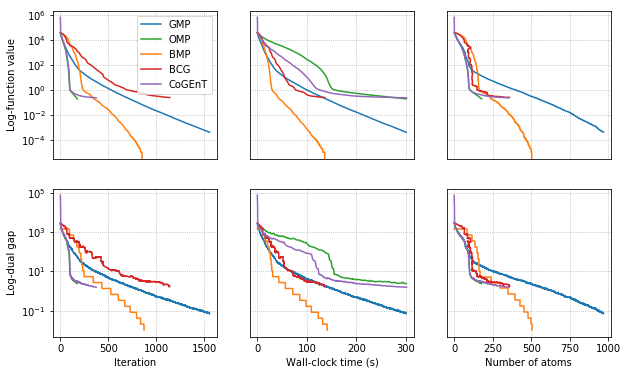

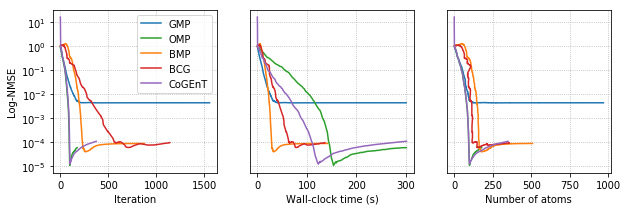

In [0]:
eta_grid = ['gmp', 'omp', 5, 'bcg', 'cogent']
eta_labels = {'gmp':'GMP', 'omp':'OMP', 5:'BMP', 'bcg':'BCG', 'cogent':'CoGEnT'}
eta_colors = {'gmp':'tab:blue', 'omp':'tab:green', 5:'tab:orange', 'bcg':'tab:red', 'cogent':'tab:purple'}

plotter(res, eta_grid, eta_labels, eta_colors)
nmse_plotter(res, eta_grid, eta_labels, eta_colors)

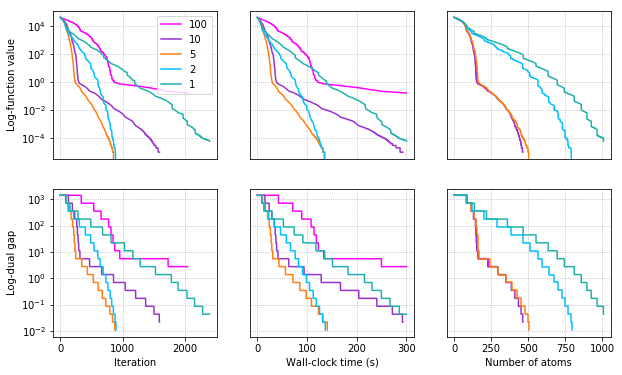

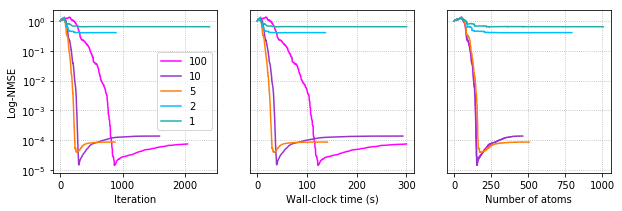

In [0]:
eta_grid = [100, 10, 5, 2, 1]
eta_labels = {100:'100', 10:'10', 5:'5', 2:'2', 1:'1'}
eta_colors = {100:'magenta', 10:'darkorchid', 5:'tab:orange', 2:'deepskyblue', 1:'lightseagreen'}

plotter(res, eta_grid, eta_labels, eta_colors)
nmse_plotter(res, eta_grid, eta_labels, eta_colors)

## Figure 3: Comparison of BMP vs. accMP

### Toy data example from [Locatello et al., On Matching Pursuit and Coordinate Descent, ICML 2018]

$\mathcal{H}=\mathbb{R}^{100}$, $\mathcal{D}$ has $200$ random atoms in $\mathcal{H}$  
$f(x)=\frac{1}{2}\|x-b\|^2_2$, $b\in\mathbb{R}^{100}$  
$\nabla f(x)=x-b$

Total CPU process time: 16.488366035000126 

********** η = 3 ********** 

Total CPU process time: 1.208471733999886 

Number of constrained steps: 100
Number of dual steps: 15
Number of full steps: 100 



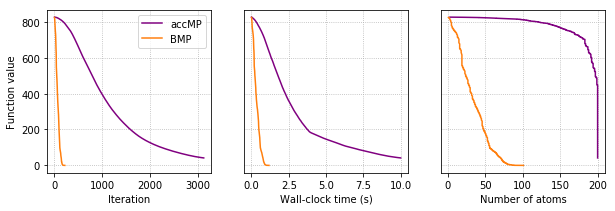

In [0]:
import matplotlib.pyplot as plt

np.random.seed(1)

n, d = 200, 100 # number of atoms, dimension of space
D, b = np.random.random((n, d)), 15*(np.random.random(d)-0.5*np.ones(d))
D = list(np.transpose(np.transpose(D)/np.linalg.norm(np.transpose(D), axis=0)))
f = lambda x: 0.5*np.linalg.norm(x-b)**2
grad_f = lambda x: x-b
x = D[np.random.randint(0, len(D))].copy()

acc_res = accMP(f, grad_f, D, x, L=1000, nu=1, f_tol=1e-10, time_tol=15)

eta_grid = [3]
res = {}

for eta in eta_grid:
    print('********** η = {} **********'.format(eta), '\n')
    res[eta] = bmp(f, grad_f, D, x, eta=eta, f_tol=1e-10, phi_tol=1e-10, time_tol=15)

eta_grid = [3]
eta_labels = {3:'BMP'}

time_break = {}
for i in range(len(acc_res[6])):
    if np.sum(acc_res[6][:i]) > 10:
        time_break['acc'] = i
        break

fig = plt.figure()
fig.set_figheight(3)
fig.set_figwidth(10)

plt.subplot(1, 3, 1)
plt.plot(acc_res[3][:time_break['acc']], acc_res[4][:time_break['acc']], color='purple', label='accMP')
for eta in eta_grid:
    plt.plot(res[eta][4], res[eta][5], label=eta_labels[eta], color='tab:orange')
plt.legend()
plt.ylabel('Function value')
plt.xlabel('Iteration')
plt.grid(which='major', linestyle=':')

plt.subplot(1, 3, 2)
plt.plot(np.cumsum(acc_res[6][:time_break['acc']]), acc_res[4][:time_break['acc']], color='purple')
for eta in eta_grid:
    plt.plot(np.cumsum(res[eta][8]), res[eta][5], color='tab:orange')
plt.xlabel('Wall-clock time (s)')
plt.tick_params(which='both', left=False, labelleft=False)
plt.grid(which='major', linestyle=':')

plt.subplot(1, 3, 3)
plt.plot(acc_res[5][:time_break['acc']], acc_res[4][:time_break['acc']], color='purple')
for eta in eta_grid:
    plt.plot(res[eta][7], res[eta][5], color='tab:orange')
plt.xlabel('Number of atoms')
plt.tick_params(which='both', left=False, labelleft=False)
plt.grid(which='major', linestyle=':')

plt.show()

## Figure 6

Comparing PGD vs. MP algorithms

In [0]:
time_tol = 300

In [0]:
m, n, s = 500, 2000, 100
sigma = 0.05

np.random.seed(1)

x_star = np.zeros(n)
nz = np.random.choice(n, s, replace=False)
for i in nz:
    x_star[i] = np.random.randn()

A = np.random.randn(m, n)
y = np.dot(A, x_star)+sigma*np.random.randn(m)
tau = np.linalg.norm(x_star, 1)

f = lambda x: np.linalg.norm(y-np.dot(A, x))**2
grad_f = lambda x: -2*np.dot(np.transpose(A), y-np.dot(A, x))
D = list(np.identity(n))+list(-np.identity(n))
x = D[np.random.randint(0, len(D))].copy()

********** η = 5 ********** 

Total CPU process time: 146.40932808 

Number of constrained steps: 349
Number of dual steps: 17
Number of full steps: 507 

********** GMP ********** 

Total CPU process time: 301.79652686400004 

********** OMP ********** 

Total CPU process time: 300.765114422 

********** scale = 0.5 ********** 

Total CPU process time: 56.280242987000065 

********** scale = 1 ********** 

Total CPU process time: 307.13422544499997 

********** scale = 2 ********** 

Total CPU process time: 10.26324985999986 



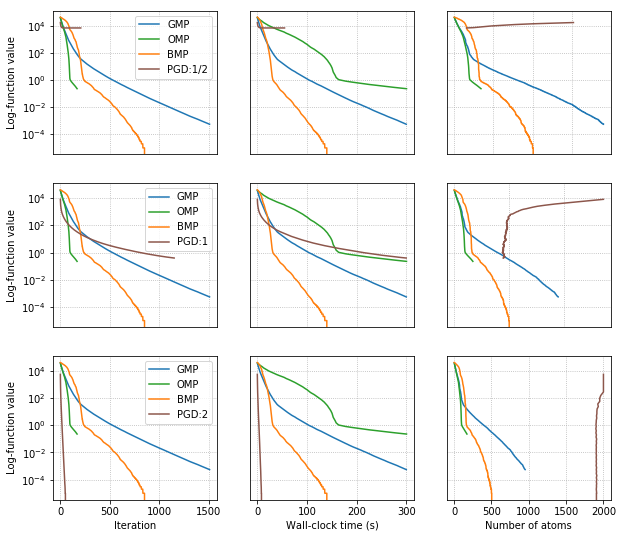

In [15]:
eta_grid = [5]

eta_labels = {'gmp':'GMP', 'omp':'OMP', 5:'BMP', 1/2:'PGD:1/2', 1:'PGD:1', 2:'PGD:2'}
eta_colors = {'gmp':'tab:blue', 'omp':'tab:green', 5:'tab:orange', 1/2:'tab:brown', 1:'tab:brown', 2:'tab:brown'}

res = {}

for eta in eta_grid:
    print('********** η = {} **********'.format(eta), '\n')
    res[eta] = bmp(f, grad_f, D, x, eta=eta, time_tol=time_tol)

print('********** GMP **********', '\n')
res['gmp'] = gmp(f, grad_f, D, x, time_tol=time_tol)

print('********** OMP **********', '\n')
res['omp'] = omp(f, grad_f, D, x, time_tol=time_tol)

fig = plt.figure()
fig.set_figheight(9)
fig.set_figwidth(10)

i = 0

for scale in [1/2, 1, 2]:
  
    algo_grid = ['gmp', 'omp', 5, scale]

    print('********** scale = {} **********'.format(scale), '\n')
    res[scale] = pgd(f, grad_f, x, scale*tau, time_tol=time_tol)

    plt.subplot(3, 3, 1+3*i)
    for eta in algo_grid:
        plt.plot(res[eta][4], res[eta][5], label=eta_labels[eta], color=eta_colors[eta])
    plt.legend()
    plt.yscale('log')
    plt.ylabel('Log-function value')
    if i == 2:
        plt.xlabel('Iteration')
        plt.tick_params(which='minor', left=False)
    else:
        plt.tick_params(which='minor', left=False)
        plt.tick_params(bottom=False, labelbottom=False)
    plt.grid(which='major', linestyle=':')

    plt.subplot(3, 3, 2+3*i)
    for eta in algo_grid:
        plt.plot(np.cumsum(res[eta][8]), res[eta][5], color=eta_colors[eta])
    plt.yscale('log')
    if i == 2:
        plt.xlabel('Wall-clock time (s)')
        plt.tick_params(which='both', left=False, labelleft=False)
    else:
        plt.tick_params(which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.grid(which='major', linestyle=':')

    plt.subplot(3, 3, 3+3*i)
    for eta in algo_grid:
        plt.plot(res[eta][7], res[eta][5], color=eta_colors[eta])
    plt.yscale('log')
    if i == 2:
        plt.xlabel('Number of atoms')
        plt.tick_params(which='both', left=False, labelleft=False)
        plt.grid(which='major', linestyle=':')
    else:
        plt.tick_params(which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.grid(which='major', linestyle=':')
    
    i += 1

plt.show()

## Figures 7 and 8-9: Regression using an arbitrarily chosen norm

Set $m=250$, $n=1000$, $s=50$, and $\sigma=0.05$  
Generate $A\in\mathbb{R}^{m\times n}$ and $x^*\in\mathbb{R}^n$ with $\|x^*\|_0=s$  
Generate $y=Ax^*+\mathcal{N}(0,\sigma^2I_m)$ and set $\rho:=\|x^*\|_1$

$f(x)=\|Ax-b\|^5_3$  
$\nabla f(x)$ using `autograd`  
$\mathcal{D}=\{\pm e_1,\ldots,\pm e_n\}$

In [0]:
time_tol = 50

In [0]:
m, n, s = 250, 1000, 50
sigma = 0.05

np.random.seed(1)

x_star = np.zeros(n)
nz = np.random.choice(n, s, replace=False)
for i in nz:
    x_star[i] = np.random.randn()

A = np.random.randn(m, n)
y = np.dot(A, x_star)+sigma*np.random.randn(m)
tau = np.linalg.norm(x_star, 1)

f = lambda x: np.linalg.norm(y-np.dot(A, x), 3)**5
grad_f = grad(f)
D = list(np.identity(n))+list(-np.identity(n))
x = D[np.random.randint(0, len(D))].copy()

In [0]:
res = {}

eta_grid = [100, 10, 5, 2, 1]

for eta in eta_grid:
    print('********** η = {} **********'.format(eta), '\n')
    res[eta] = bmp(f, grad_f, D, x, x_star=x_star, eta=eta, time_tol=time_tol)

print('********** GMP **********', '\n')
res['gmp'] = gmp(f, grad_f, D, x, x_star=x_star, time_tol=time_tol)

print('********** OMP **********', '\n')
res['omp'] = omp(f, grad_f, D, x, x_star=x_star, time_tol=time_tol)

print('********** BCG **********', '\n')
res['bcg'] = bcg(f, grad_f, D, tau, x, x_star=x_star, time_tol=time_tol)

print('********** CoGEnT **********', '\n')
res['cogent'] = cogent(f, grad_f, D, x, tau, x_star=x_star, time_tol=time_tol)

********** η = 100 ********** 

Total CPU process time: 50.73194268299994 

Number of constrained steps: 941
Number of dual steps: 36
Number of full steps: 115 

********** η = 10 ********** 

Total CPU process time: 22.461008528000093 

Number of constrained steps: 293
Number of dual steps: 40
Number of full steps: 143 

********** η = 5 ********** 

Total CPU process time: 14.381006261000039 

Number of constrained steps: 109
Number of dual steps: 40
Number of full steps: 147 

********** η = 2 ********** 

Total CPU process time: 20.143170850000388 

Number of constrained steps: 46
Number of dual steps: 41
Number of full steps: 251 

********** η = 1 ********** 

Total CPU process time: 38.57493500999999 

Number of constrained steps: 0
Number of dual steps: 40
Number of full steps: 746 

********** GMP ********** 

Total CPU process time: 45.2145415050004 

********** OMP ********** 

Total CPU process time: 50.72753528500016 

********** BCG ********** 

Total CPU process time: 46

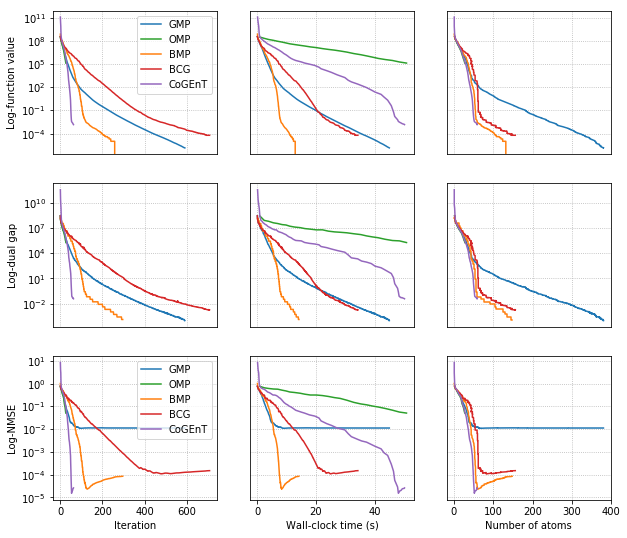

In [0]:
eta_grid = ['gmp', 'omp', 5, 'bcg', 'cogent']
eta_labels = {'gmp':'GMP', 'omp':'OMP', 5:'BMP', 'bcg':'BCG', 'cogent':'CoGEnT'}
eta_colors = {'gmp':'tab:blue', 'omp':'tab:green', 5:'tab:orange', 'bcg':'tab:red', 'cogent':'tab:purple'}

nmse_plotter_full(res, eta_grid, eta_labels, eta_colors)

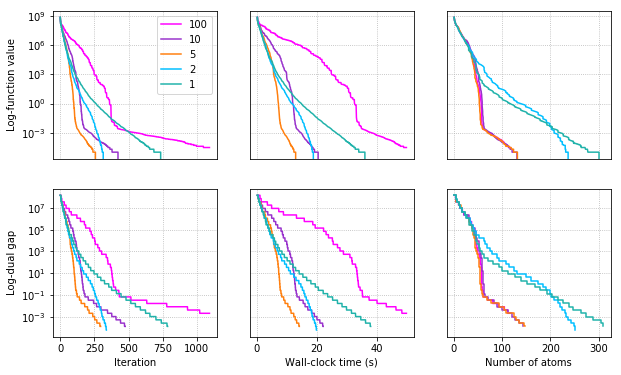

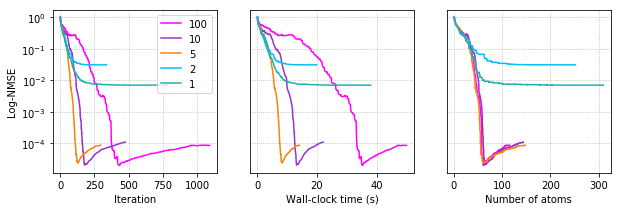

In [0]:
eta_grid = [100, 10, 5, 2, 1]
eta_labels = {100:'100', 10:'10', 5:'5', 2:'2', 1:'1'}
eta_colors = {100:'magenta', 10:'darkorchid', 5:'tab:orange', 2:'deepskyblue', 1:'lightseagreen'}

plotter(res, eta_grid, eta_labels, eta_colors)
nmse_plotter(res, eta_grid, eta_labels, eta_colors)

## Figures 10 and 11-12: Huber loss

Set $m=250$, $n=1000$, $s=50$, and $\sigma=0.05$  
Generate $A\in\mathbb{R}^{m\times n}$ and $x^*\in\mathbb{R}^n$ with $\|x^*\|_0=s$  
Generate $y=Ax^*+\mathcal{N}(0,\sigma^2I_m)$ and set $\rho:=\|x^*\|_1$

$f(x)=\sum_{i=1}^{m}h_{10}(a_i^\top x-y_i)$, $A\in\mathbb{R}^{m\times n}$ with rows $a_1^\top,\ldots,a_{m}^\top\in\mathbb{R}^{1\times n}$  
$\nabla f(x)=\sum_{i=1}^{m}h_{10}'(a_i^\top x-y_i)a_i$  
$\mathcal{D}=\{\pm e_1,\ldots,\pm e_n\}$

In [0]:
time_tol = 200

In [0]:
m, n, s = 250, 1000, 50
sigma = 0.05

np.random.seed(1)

x_star = np.zeros(n)
nz = np.random.choice(n, s, replace=False)
for i in nz:
    x_star[i] = np.random.randn()

A = np.random.randn(m, n)
y = np.dot(A, x_star)+sigma*np.random.randn(m)
tau = np.linalg.norm(x_star, 1)

def huber(t, delta):
    if abs(t) <= delta:
        return t**2/2
    else:
        return delta*(abs(t)-delta/2)

def der_huber(t, delta):
    if abs(t) <= delta:
        return t
    elif t > delta:
        return delta
    else:
        return -delta

delta = 10

f = lambda x: sum([huber(np.dot(A[i], x)-y[i], delta) for i in range(m)])
grad_f = lambda x: sum([der_huber(np.dot(A[i], x)-y[i], delta)*A[i] for i in range(m)])
D = list(np.identity(n))+list(-np.identity(n))
x = D[np.random.randint(0, len(D))].copy()

In [0]:
res = {}

eta_grid = [100, 10, 5, 2, 1]

for eta in eta_grid:
    print('********** η = {} **********'.format(eta), '\n')
    res[eta] = bmp(f, grad_f, D, x, x_star=x_star, eta=eta, time_tol=time_tol)

print('********** GMP **********', '\n')
res['gmp'] = gmp(f, grad_f, D, x, x_star=x_star, time_tol=time_tol)

print('********** OMP **********', '\n')
res['omp'] = omp(f, grad_f, D, x, x_star=x_star, time_tol=time_tol)

print('********** BCG **********', '\n')
res['bcg'] = bcg(f, grad_f, D, tau, x, x_star=x_star, time_tol=time_tol)

print('********** CoGEnT **********', '\n')
res['cogent'] = cogent(f, grad_f, D, x, tau, x_star=x_star, time_tol=time_tol)

********** η = 100 ********** 

Total CPU process time: 200.80197740199992 

Number of constrained steps: 464
Number of dual steps: 8
Number of full steps: 85 

********** η = 10 ********** 

Total CPU process time: 200.84800793800014 

Number of constrained steps: 381
Number of dual steps: 11
Number of full steps: 183 

********** η = 5 ********** 

Total CPU process time: 168.03086098699987 

Number of constrained steps: 233
Number of dual steps: 15
Number of full steps: 241 

********** η = 2 ********** 

Total CPU process time: 167.49693160900006 

Number of constrained steps: 68
Number of dual steps: 17
Number of full steps: 398 

********** η = 1 ********** 

Total CPU process time: 200.76329696799985 

Number of constrained steps: 1
Number of dual steps: 7
Number of full steps: 575 

********** GMP ********** 

Total CPU process time: 200.93054136 

********** OMP ********** 

Total CPU process time: 204.04336817800004 

********** BCG ********** 

Total CPU process time: 208.14

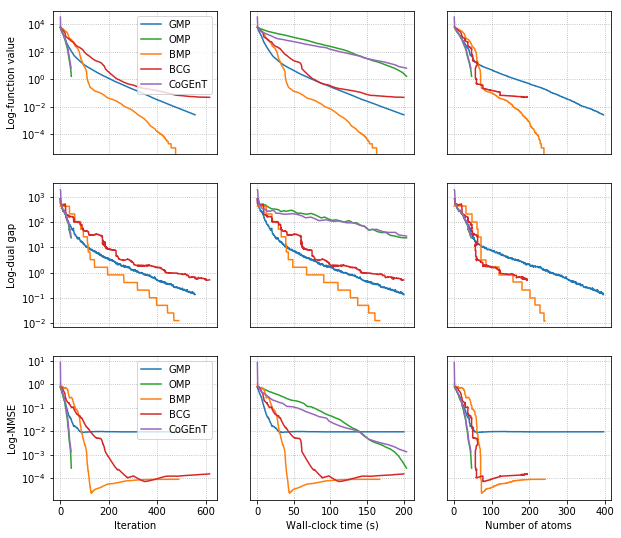

In [0]:
eta_grid = ['gmp', 'omp', 5, 'bcg', 'cogent']
eta_labels = {'gmp':'GMP', 'omp':'OMP', 5:'BMP', 'bcg':'BCG', 'cogent':'CoGEnT'}
eta_colors = {'gmp':'tab:blue', 'omp':'tab:green', 5:'tab:orange', 'bcg':'tab:red', 'cogent':'tab:purple'}

nmse_plotter_full(res, eta_grid, eta_labels, eta_colors)

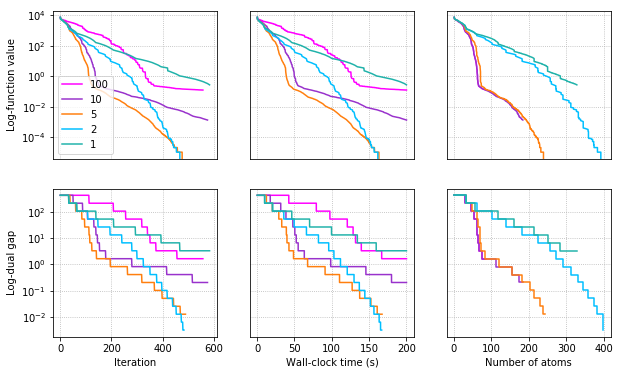

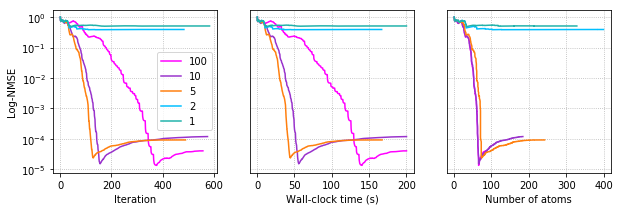

In [0]:
eta_grid = [100, 10, 5, 2, 1]
eta_labels = {100:'100', 10:'10', 5:'5', 2:'2', 1:'1'}
eta_colors = {100:'magenta', 10:'darkorchid', 5:'tab:orange', 2:'deepskyblue', 1:'lightseagreen'}

plotter(res, eta_grid, eta_labels, eta_colors)
nmse_plotter(res, eta_grid, eta_labels, eta_colors)

## Figure 13: Distance to a convex set

$\mathcal{H}=\mathbb{R}^{500}$, $\mathcal{D}$ has $750$ random atoms in $\mathcal{H}$  
$f(x)=\|(Ax-b)-\operatorname{proj}_{\overline{\mathcal{B}}(0,1)}(Ax-b)\|^2_2$, $A\in\mathbb{R}^{500\times 500}$, $b\in\mathbb{R}^{500}$  
$\nabla f(x)$ using `autograd`

In [0]:
time_tol = 1000

********** η = 10 ********** 

Total CPU process time: 1006.396874172 

Number of constrained steps: 4890
Number of dual steps: 9
Number of full steps: 462 

********** η = 2 ********** 

Total CPU process time: 1005.9459277639999 

Number of constrained steps: 4466
Number of dual steps: 12
Number of full steps: 488 

********** GMP ********** 

Total CPU process time: 1016.0224976760001 

********** OMP ********** 

Total CPU process time: 1002.5655982400003 



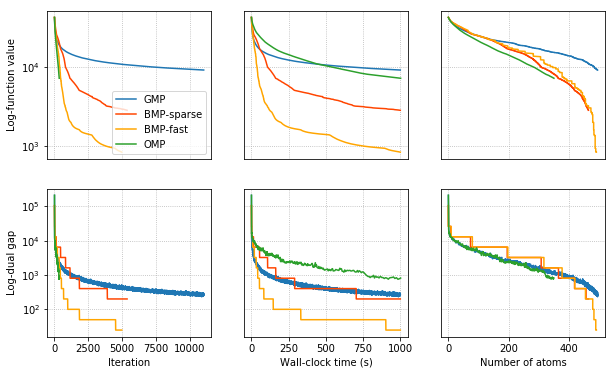

In [0]:
m, n, d = 500, 500, 750
A, b = 10*np.random.randn(m, n), 10*np.random.randn(m)

def p(x):
    if np.linalg.norm(x) <= 1:
        return x
    else:
        return x/np.linalg.norm(x)

np.random.seed(1)

f = lambda x: np.linalg.norm((np.matmul(A, x)-b)-p(np.matmul(A, x)-b))**2
grad_f = grad(f)
D = list(10*np.random.randn(d, n))
D = list(np.transpose(np.transpose(A)/np.linalg.norm(np.transpose(A), axis=0)))
x = D[np.random.randint(0, len(D))].copy()

eta_grid = [10, 2]
res = {}

for eta in eta_grid:
    print('********** η = {} **********'.format(eta), '\n')
    res[eta] = bmp(f, grad_f, D, x, eta=eta, f_tol=1e-10, phi_tol=1e-10, time_tol=time_tol, tol=1e-3)

print('********** GMP **********', '\n')
res['gmp'] = gmp(f, grad_f, D, x, f_tol=1e-10, time_tol=time_tol, tol=1e-3)

print('********** OMP **********', '\n')
res['omp'] = omp(f, grad_f, D, x, f_tol=1e-10, time_tol=time_tol, tol=1e-3)

eta_grid = ['gmp', 10, 2, 'omp']
eta_labels = {'gmp':'GMP', 10:'BMP-sparse', 2:'BMP-fast', 'omp':'OMP'}
eta_colors = {'gmp':'tab:blue', 10:'orangered', 2:'orange', 'omp':'tab:green'}
plotter(res, eta_grid, eta_labels, eta_colors)

## Figure 14: Sensitivity analysis for the distance to a convex set

In [0]:
time_tol = 1000

********** η = 1000 ********** 

Total CPU process time: 1008.7370764850002 

Number of constrained steps: 6405
Number of dual steps: 6
Number of full steps: 350 

********** η = 100 ********** 

Total CPU process time: 1007.6244596400011 

Number of constrained steps: 5777
Number of dual steps: 7
Number of full steps: 395 

********** η = 10 ********** 

Total CPU process time: 1006.3149312869991 

Number of constrained steps: 4911
Number of dual steps: 9
Number of full steps: 459 

********** η = 2 ********** 

Total CPU process time: 1005.7472569620004 

Number of constrained steps: 4473
Number of dual steps: 12
Number of full steps: 486 

********** η = 1 ********** 

Total CPU process time: 1006.2187445790005 

Number of constrained steps: 4032
Number of dual steps: 13
Number of full steps: 1266 

********** η = 0.1 ********** 

Total CPU process time: 1018.0497237460004 

Number of constrained steps: 0
Number of dual steps: 8
Number of full steps: 11365 



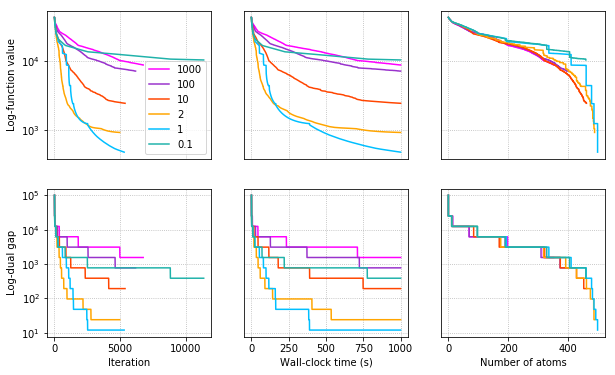

In [0]:
m, n, d = 500, 500, 750
A, b = 10*np.random.randn(m, n), 10*np.random.randn(m)

np.random.seed(1)

def p(x):
    if np.linalg.norm(x) <= 1:
        return x
    else:
        return x/np.linalg.norm(x)

f = lambda x: np.linalg.norm((np.matmul(A, x)-b)-p(np.matmul(A, x)-b))**2
grad_f = grad(f)
D = list(10*np.random.randn(d, n))
D = list(np.transpose(np.transpose(A)/np.linalg.norm(np.transpose(A), axis=0)))
x = D[np.random.randint(0, len(D))].copy()

eta_grid = [1000, 100, 10, 2, 1, 0.1]
res = {}

for eta in eta_grid:
    print('********** η = {} **********'.format(eta), '\n')
    res[eta] = bmp(f, grad_f, D, x, eta=eta, f_tol=1e-10, phi_tol=1e-10, time_tol=time_tol, tol=1e-3)

eta_labels = {1000:'1000', 100:'100', 10:'10', 2:'2', 1:'1', 0.1:'0.1'}
eta_colors = {1000:'magenta', 100:'darkorchid', 10:'orangered', 
              2:'orange', 1:'deepskyblue', 0.1:'lightseagreen'}
plotter(res, eta_grid, eta_labels, eta_colors)

## Figure 15: Logistic regression on the Gisette dataset

> I. Guyon, S. Gunn, and A. Ben-Hur, and G. Dror. Result analysis of the NIPS 2003 feature selection challenge. In *Advances in Neural Information Processing Systems 17*, pages 545$-$552. 2005.

Dataset available at: https://archive.ics.uci.edu/ml/datasets/Gisette

$f(x)=\displaystyle\frac{1}{m}\sum_{i=1}^m\ln\left(\frac{1}{1+e^{-y_ia_i^\top x}}\right)$  
$\nabla f(x)=\displaystyle-\frac{2}{m}\sum_{i=1}^m\frac{y_ie^{-y_ia_i^\top x}}{1+e^{-y_ia_i^\top x}}a_i$  
$\mathcal{D}=\{\pm e_1,\ldots,\pm e_n\}$

In [0]:
time_tol = 3000

In [0]:
def weak_separation(c, phi, kappa, S_idx, D):
        
    # try find in cache
    s_idx = np.argmin(-np.abs(list(map(lambda i: c[i] if i in S_idx else 0, np.arange(len(c))))))
    if s_idx in S_idx:
        if -abs(c[s_idx]) <= phi/kappa:
            return D[s_idx].copy(), s_idx, 'FIC'
    
    # else try elsewhere
    v_idx = np.argmin(-abs(c))
    if -abs(c[v_idx]) <= phi/kappa:
        return D[v_idx].copy(), v_idx, 'FI'

    # if still nothing
    return 0, 0, 'FN'

def bmp(f, grad_f, D, x, eta=2, kappa=2, tau=2, 
        f_tol=1e-10, phi_tol=1e-10, time_tol=np.inf, tol=1e-6, verbosity=False, digits=5):
    
    start_time = process_time()
    
    S, S_idx, alpha = [x], [find_index(x, D)], 1
    phi = np.min(-abs(grad_f(x)))/tau
    
    f_improv, phi_improv = np.inf, np.inf
    iter_nums, iter_types, iter_values, iter_bounds, iter_atoms, iter_times = [], [], [], [], [], []
    num_cons, num_dual, num_full = 0, 0, 0
    
    while (f_improv > f_tol or phi_improv > phi_tol) and np.sum(iter_times) < time_tol:
        
        iter_start_time = process_time()
        f_old, phi_old = f(x), phi
        
        grad_f_x = grad_f(x)
        min_FW_S = np.min(-np.abs(list(map(lambda i: grad_f_x[i] if i in S_idx else 0, np.arange(len(grad_f_x))))))

        v_idx = np.argmin(-abs(grad_f_x))
        phi = -abs(grad_f_x[v_idx])
        
        if min_FW_S <= phi/eta:
            
            iter_types.append('C')
            num_cons += 1
            
            proj_grad, beta, S_basis = proj(grad_f_x, S)
            x, gamma = line_search(f, grad_f, x, proj_grad, tol)
            
        else:
                
            v = D[v_idx].copy()
            iter_types.append('F')
            num_full += 1
            x, gamma = line_search(f, grad_f, x, v, tol)
            if v_idx not in S_idx:
                S.append(v)
                S_idx.append(v_idx)
        
        f_improv, phi_improv = f_old-f(x), phi-phi_old
        
        iter_end_time = process_time()
        iter_times.append(round(iter_end_time-iter_start_time, digits))
        if len(iter_nums) == 0:
            iter_nums.append(1)
        else:
            iter_nums.append(iter_nums[-1]+1)
        iter_values.append(round(f(x), digits))
        iter_bounds.append(round(-phi, digits))
        iter_atoms.append(len(S))
    
    end_time = process_time()
    
    print('Total CPU process time:', end_time-start_time, '\n')
    print('Number of constrained steps:', num_cons)
    print('Number of dual steps:', num_dual)
    print('Number of full steps:', num_full, '\n')
    
    if verbosity == True:
        print(tabulate(np.transpose([iter_nums, iter_types, iter_values, iter_bounds, iter_atoms, iter_times]), 
                       headers=['Iteration', 'Type', 'Function value', 'Dual gap', 
                                'Atoms', 'CPU time'], tablefmt='simple'), '\n')
    
    return x, f(x), S, alpha, iter_nums, iter_values, iter_bounds, iter_atoms, iter_times, iter_types

def gmp(f, grad_f, D, x, f_tol=1e-10, time_tol=np.inf, tol=1e-6):
    
    start_time = process_time()
    
    S, S_idx, alpha = [x], [find_index(x, D)], 1
    phi = np.min(-abs(grad_f(x)))
    
    f_improv = np.inf
    iter_nums, iter_values, iter_bounds, iter_atoms, iter_times = [], [], [], [], []
    
    while f_improv > f_tol and np.sum(iter_times) < time_tol:
        
        iter_start_time = process_time()
        f_old, phi_old = f(x), phi
        
        grad_f_x = grad_f(x)
        v_idx = np.argmin(-abs(grad_f_x))
        v = D[v_idx].copy()
        phi = -abs(grad_f_x[v_idx])
        x, gamma = line_search(f, grad_f, x, v, tol)
        if v_idx not in S_idx:
            S.append(v)
            S_idx.append(v_idx)
        
        f_improv = f_old-f(x)
        
        iter_end_time = process_time()
        iter_times.append(iter_end_time-iter_start_time)
        if len(iter_nums) == 0:
            iter_nums.append(1)
        else:
            iter_nums.append(iter_nums[-1]+1)
        iter_values.append(f(x))
        iter_bounds.append(-phi)
        iter_atoms.append(len(S))
    
    end_time = process_time()
    
    print('Total CPU process time:', end_time-start_time, '\n')
        
    return x, f(x), S, alpha, iter_nums, iter_values, iter_bounds, iter_atoms, iter_times

def omp(f, grad_f, D, x, f_tol=1e-10, time_tol=np.inf, tol=1e-6):
    
    start_time = process_time()
    
    S, S_idx, alpha = [x], [find_index(x, D)], 1
    phi = np.min(-abs(grad_f(x)))
    
    f_improv = np.inf
    iter_nums, iter_values, iter_bounds, iter_atoms, iter_times = [], [], [], [], []
    
    while f_improv > f_tol and np.sum(iter_times) < time_tol:
        
        iter_start_time = process_time()
        f_old, phi_old = f(x), phi
        
        grad_f_x = grad_f(x)
        v_idx = np.argmin(-abs(grad_f_x))
        v = D[v_idx].copy()
        phi = -abs(grad_f_x[v_idx])
        
        if v_idx not in S_idx:
            S.append(v)
            S_idx.append(v_idx)
        
        x, alpha = minimization(f, grad_f, S, x, alpha, tol)
        
        f_improv = f_old-f(x)
        
        iter_end_time = process_time()
        iter_times.append(iter_end_time-iter_start_time)
        if len(iter_nums) == 0:
            iter_nums.append(1)
        else:
            iter_nums.append(iter_nums[-1]+1)
        iter_values.append(f(x))
        iter_bounds.append(-phi)
        iter_atoms.append(len(S))
    
    end_time = process_time()
    
    print('Total CPU process time:', end_time-start_time, '\n')
        
    return x, f(x), S, alpha, iter_nums, iter_values, iter_bounds, iter_atoms, iter_times

In [0]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

np.random.seed(1)

A = pd.read_csv('gisette_train.data', sep=' ', header=None).iloc[:1000,:-1]
y = pd.read_csv('gisette_train.labels', sep=' ', header=None)[0].values[:1000]

scaler = StandardScaler()
A = scaler.fit_transform(A)

print(A.shape, y.shape)

m, n = A.shape
k = 1
f = lambda x: sum(list(map(lambda t: np.log(1+np.exp(-k*t)), y*np.dot(A, x))))/m
grad_f = lambda x: -2*np.dot(y*list(map(lambda t: np.exp(-k*t)/(1+np.exp(-k*t)), y*np.dot(A, x))), A)/m
D = list(np.identity(n))+list(-np.identity(n))
x = D[np.random.randint(0, len(D))].copy()

(1000, 5000) (1000,)


In [0]:
res = {}

eta_grid = [3, 2]

for eta in eta_grid:
    print('********** η = {} **********'.format(eta), '\n')
    res[eta] = bmp(f, grad_f, D, x, eta=eta, f_tol=1e-6, phi_tol=1e-6, time_tol=time_tol)

print('********** GMP **********', '\n')
res['gmp'] = gmp(f, grad_f, D, x, f_tol=1e-6, time_tol=time_tol)

print('********** OMP **********', '\n')
res['omp'] = omp(f, grad_f, D, x, f_tol=1e-6, time_tol=time_tol)

********** η = 3 ********** 

Total CPU process time: 568.264558352 

Number of constrained steps: 219
Number of dual steps: 0
Number of full steps: 80 

********** η = 2 ********** 

Total CPU process time: 477.84555305599997 

Number of constrained steps: 147
Number of dual steps: 0
Number of full steps: 101 

********** GMP ********** 

Total CPU process time: 417.2327749400001 

********** OMP ********** 



/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


Total CPU process time: 3029.545304929 



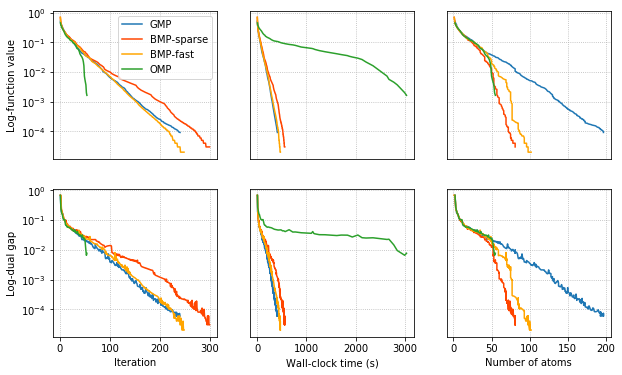

In [0]:
eta_grid = ['gmp', 3, 2, 'omp']
eta_labels = {'gmp':'GMP', 3:'BMP-sparse', 2:'BMP-fast', 'omp':'OMP'}
eta_colors = {'gmp':'tab:blue', 3:'orangered', 2:'orange', 'omp':'tab:green'}

plotter(res, eta_grid, eta_labels, eta_colors)